In [ ]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import time
from torch.utils.data import Subset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_data_loader(batch_size=32, total_sample_num=None):
    """
     Loads data from a single root directory with class subfolders, splits it
     into train, validation and test sets with equal representation, and
     returns data loaders.

     Args:
         batch_size: The batch size for the data loaders.
         total_sample_num: The total number of samples to use from the dataset.
                           If None, the entire dataset is used.
    """

    data_dir_root = '/content/drive/My Drive/APS360GroupProject-TrafficSystem/final_processed3/final_processed' # Root directory

    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1), # Add grayscale conversion
         transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))]) # Normalize for a single channel


    # Load Image Folder dataset from the root directory
    full_dataset = torchvision.datasets.ImageFolder(root=data_dir_root, transform=transform)

    # Get all indices and optionally limit the total number of samples
    all_indices = list(range(len(full_dataset)))
    if total_sample_num is not None and total_sample_num < len(all_indices):
        np.random.seed(1000) # Fixed numpy random seed for reproducible sampling
        all_indices = np.random.choice(all_indices, size=total_sample_num, replace=False).tolist()


    # Get indices for each class within the (potentially limited) set of all_indices
    attentive_indices = [i for i in all_indices if full_dataset.classes[full_dataset.targets[i]] == 'attentive']
    distracted_indices = [i for i in all_indices if full_dataset.classes[full_dataset.targets[i]] == 'distracted']

    # Combine all indices before splitting to ensure randomness across the entire (potentially limited) dataset
    combined_indices = attentive_indices + distracted_indices

    # Shuffle the combined indices
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(combined_indices)


    # Split into train, validation, and test (60%, 10%, 10%)
    split_1 = int(len(combined_indices) * 0.6) #split at 60% for training
    split_2 = int(len(combined_indices) * 0.7) #split at 60% + 10% = 70% for validation
    split_3 = int(len(combined_indices) * 0.8) #split at 70% + 10% = 80% for testing
    # The remaining 20% will be for the "unseen" set

    # split into training, validation, test, and unseen indices
    train_indices = combined_indices[:split_1]
    val_indices = combined_indices[split_1:split_2]
    test_indices = combined_indices[split_2:split_3]
    unseen_indices = combined_indices[split_3:] # The remaining indices for the unseen set


    # Create Subset datasets for each split
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)
    unseen_dataset = Subset(full_dataset, unseen_indices)


    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
    unseen_loader = torch.utils.data.DataLoader(unseen_dataset, batch_size=batch_size, num_workers=1, shuffle=False)


    return train_loader, val_loader, test_loader, unseen_loader # Return the new unseen loader

In [ ]:
def plot_training_curve(path, run_name="default_run", learning_rate=None, batch_size=None):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss/accuracy/recall.

    Args:
        path: The base path of the csv files produced during training
        run_name: The name of the training run.
        learning_rate: The learning rate used for the run.
        batch_size: The batch size used for the run.
    """
    import matplotlib.pyplot as plt
    # Construct filename base using run_name and hyperparameters
    csv_filename_base = f"{path}{run_name}"
    if learning_rate is not None:
        csv_filename_base += f"_lr{learning_rate}"
    if batch_size is not None:
        csv_filename_base += f"_bs{batch_size}"


    train_err = np.loadtxt(f"{csv_filename_base}_train_err.csv")
    val_err = np.loadtxt(f"{csv_filename_base}_val_err.csv")
    train_loss = np.loadtxt(f"{csv_filename_base}_train_loss.csv")
    val_loss = np.loadtxt(f"{csv_filename_base}_val_loss.csv")
    train_accuracy = np.loadtxt(f"{csv_filename_base}_train_accuracy.csv") # Load train accuracy
    val_accuracy = np.loadtxt(f"{csv_filename_base}_val_accuracy.csv")   # Load validation accuracy
    train_recall = np.loadtxt(f"{csv_filename_base}_train_recall.csv")   # Load train recall
    val_recall = np.loadtxt(f"{csv_filename_base}_val_recall.csv")     # Load validation recall

    title_suffix = f" ({run_name}"
    if learning_rate is not None:
        title_suffix += f", LR={learning_rate}"
    if batch_size is not None:
        title_suffix += f", BS={batch_size}"
    title_suffix += ")"


    plt.title(f"Train vs Validation Error{title_suffix}") # Changed title
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title(f"Train vs Validation Loss{title_suffix}") # Changed title
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # New plot for Accuracy
    plt.title(f"Train vs Validation Accuracy{title_suffix}") # Changed title
    plt.plot(range(1,n+1), train_accuracy, label="Train")
    plt.plot(range(1,n+1), val_accuracy, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # New plot for Recall
    plt.title(f"Train vs Validation Recall{title_suffix}") # Changed title
    plt.plot(range(1,n+1), train_recall, label="Train")
    plt.plot(range(1,n+1), val_recall, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_relevant_indices(dataset, sample_num=200):
    """ Return a list of indices for a specified sample size.

    Args:
        dataset: Dataset object
        sample_num: The desired number of indices to return.
    Returns:
        indices: list of indices up to sample_num or the total number of indices if sample_num is larger.
    """
    # Get all indices
    all_indices = list(range(len(dataset)))

    # Return up to sample_num indices
    return all_indices[:min(sample_num, len(all_indices))]

In [ ]:
class Primary(nn.Module): ## include skip connections and intermediatery loss funcs
  def __init__(self):
    super(Primary, self).__init__()
    self.name="PrimaryNET"

    # Assuming input size is 32x32
    self.conv1 = nn.Conv2d(1, 32, 3, 1, 1) # Input channels: 1 (for grayscale), Output: 32, Kernel: 3x3, Stride: 1, Padding: 1
    self.pool = nn.MaxPool2d(2,2) # Output size after conv1 and pool: 32x32 / 2 = 16x16
    self.conv2 = nn.Conv2d(32, 64, 3, 1, 1) # Input channels: 32, Output: 64, Kernel: 3x3, Stride: 1, Padding: 1
    # Output size after conv2: 16x16
    self.conv3 = nn.Conv2d(64, 128, 3, 1, 1) # Input channels: 64, Output: 128, Kernel: 3x3, Stride: 1, Padding: 1
    # Output size after conv3: 16x16

    # skip_conv needs to downsample from 32x32 (output of conv1) to 8x8 and change channels from 32 to 128
    # A single conv layer with stride 4 would achieve 32x32 -> 8x8.
    # Or a conv with stride 2 followed by a pool.
    # Let's stick to the skip connection from after the first pool (16x16, 32 channels) to after conv3 (8x8, 128 channels).
    # This requires downsampling by a factor of 2 spatially (16->8) and changing channels (32->128).
    # The skip_conv with stride=2 and output channels 128 is appropriate for this.
    self.skip_conv = nn.Conv2d(32, 128, 1, stride=2) # Input channels: 32, Output: 128, Kernel: 1x1, Stride: 2, Padding: 0

    # Auxiliary output layers - adjusting input features based on spatial size after relevant layers
    # After conv2 (output size 16x16)
    self.aux_fc1 = nn.Linear(16 * 16 * 64, 1) # Input features based on flattened conv2 output
    # After conv3 and skip connection (output size 8x8)
    self.aux_fc2 = nn.Linear(8 * 8 * 128, 1) # Input features based on flattened output after conv3 and skip

    # Final pooling before linear layers - output size after pool: 8x8 / 2 = 4x4
    self.fc1 = nn.Linear(8 * 8 * 128, 64) # Input features based on flattened output after conv3 and skip
    self.dropout=nn.Dropout(0.5)
    self.fc2 = nn.Linear(64, 1) # Output classes: 1 for binary classification

  def forward(self,x):
    # First convolutional block
    x = F.relu(self.conv1(x)) # Input: 1 channels, Output: 32 channels, Size: 32x32
    identity = x # Save for skip connection before first pool

    x = self.pool(x) # Input: 32x32, Output: 16x16

    # Second convolutional block
    x = F.relu(self.conv2(x)) # Input: 16x16, 32 channels, Output: 16x16, 64 channels
    # Auxiliary output 1 based on output of conv2 before next pool
    aux1 = self.aux_fc1(x.view(-1, 16 * 16 * 64))
    x = self.pool(x) # Input: 16x16, Output: 8x8

    # Third convolutional block
    x = F.relu(self.conv3(x)) # Input: 8x8, 64 channels, Output: 8x8, 128 channels

    # Apply skip connection: from output after first pool (identity after first pool, 16x16, 32 channels)
    # to be added to output after conv3 (x, 8x8, 128 channels).
    # Apply the skip_conv to the identity tensor saved *before* the first pooling,
    # and the stride=2 in skip_conv along with the pooling in the main path should align dimensions.
    identity = self.pool(identity) # Apply pool to the identity saved before the first pool. identity is now 16x16, 32 channels
    identity = self.skip_conv(identity) # Apply skip_conv (stride=2) to the pooled identity. identity is now 8x8, 128 channels.

    x = x + identity # Both are now 8x8, 128 channels. This is where the addition happens.

    # Auxiliary output 2 based on output after conv3 and skip connection
    aux2 = self.aux_fc2(x.view(-1, 8 * 8 * 128)) # Flatten the combined tensor

    # Final linear layers
    x = x.view(-1, 8 * 8 * 128) # Flatten the tensor for linear layers
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x, aux1, aux2 # Return main output and auxiliary outputs

In [ ]:
class SimplePrimary(nn.Module):
    def __init__(self):
        super(SimplePrimary, self).__init__()
        self.name = "SimplePrimaryNET"

        # Assuming input size is 32x32
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)  # Input channels: 1 (for grayscale), Output: 32, Kernel: 3x3, Stride: 1, Padding: 1
        self.pool = nn.MaxPool2d(2, 2)  # Output size after conv1 and pool: 32x32 / 2 = 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)  # Input channels: 32, Output: 64, Kernel: 3x3, Stride: 1, Padding: 1
        # Output size after conv2: 16x16

        # Skip connection from after first pool (16x16, 32 channels) to after conv2 (16x16, 64 channels)
        # This requires changing channels from 32 to 64. No spatial downsampling needed in skip connection.
        self.skip_conv = nn.Conv2d(32, 64, 1, stride=1) # Input channels: 32, Output: 64, Kernel: 1x1, Stride: 1, Padding: 0

        # Auxiliary output layer after conv2 (output size 16x16)
        self.aux_fc = nn.Linear(16 * 16 * 64, 1) # Input features based on flattened conv2 output

        # Final pooling before linear layers - output size after conv2 and pool: 16x16 / 2 = 8x8
        self.fc1 = nn.Linear(8 * 8 * 64, 32) # Adjusted input features and output size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 1) # Output classes: 1 for binary classification

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x)) # Output size: 32x32
        x = self.pool(x) # Output size: 16x16
        identity = x # Save for skip connection *after* first pool: 16x16, 32 channels

        # Second convolutional block
        x = F.relu(self.conv2(x)) # Input: 16x16, 32 channels, Output: 16x16, 64 channels

        # Apply skip connection transformation to the identity tensor (output of first pool)
        identity = self.skip_conv(identity) # identity is now 16x16, 64 channels

        # Add the skip connection to the output of conv2
        x = x + identity # Both are now 16x16, 64 channels. This is where the addition happens.


        # Auxiliary output based on output after conv2 and skip connection
        aux = self.aux_fc(x.view(-1, 16 * 16 * 64)) # Flatten the combined tensor

        # Final pooling before linear layers
        x = self.pool(x) # Input: 16x16, Output: 8x8

        # Final linear layers
        x = x.view(-1, 8 * 8 * 64) # Flatten the tensor for linear layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x, aux # Return main output and the single auxiliary output

In [ ]:
def evaluate(net, loader, auxiliary_weight=0.4):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
         accuracy: A scalar for the average accuracy over the validation set
         true_positives: The number of true positive predictions.
         true_negatives: The number of true negative predictions.
         false_positives: The number of false positive predictions.
         false_negatives: The number of false negative predictions.
         recall: A scalar for the recall over the validation set.
     """
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for binary classification

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for inputs, labels in loader:
            # Ensure labels are float for BCEWithLogitsLoss
            labels = labels.float().unsqueeze(1)
            outputs_tuple = net(inputs) # Get all outputs from the model
            outputs = outputs_tuple[0] # Main output is the first element
            aux_outputs = outputs_tuple[1:] # Auxiliary outputs are the rest

            main_loss = criterion(outputs, labels)
            loss = main_loss
            for aux_output in aux_outputs:
                loss += auxiliary_weight * criterion(aux_output, labels) # Add auxiliary losses with weight


            total_loss += loss.item() * inputs.size(0) # Accumulate weighted loss
            predicted = torch.round(torch.sigmoid(outputs)) # Apply sigmoid and round for binary prediction
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Calculate TP, TN, FP, FN
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()


    err = 1.0 - (correct_predictions / total_samples) # Calculate error rate
    loss = total_loss / total_samples # Calculate average loss
    accuracy = correct_predictions / total_samples # Calculate accuracy

    # Calculate Recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0


    return err, loss, accuracy, true_positives, true_negatives, false_positives, false_negatives, recall # Return additional metrics and recall

In [ ]:
def train_net(net, train_loader, val_loader, test_loader, batch_size=32, learning_rate=0.01, num_epochs=10, _momentum=0.9, auxiliary_weight=0.4, run_name="default_run"):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    # train_loader, val_loader, test_loader = get_data_loader(batch_size=batch_size, total_sample_num=total_sample_num) # Removed internal call
    ########################################################################
    #Set CRITERION AND OPTIMIZER
    criterion = nn.BCEWithLogitsLoss() #LOSS FUNCTION: Binary Cross Entropy with Logits for binary classification
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=_momentum) #OPTIMIZER
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    train_accuracy = np.zeros(num_epochs) # Array to store training accuracy
    train_recall = np.zeros(num_epochs)  # Array to store training Recall
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs)
    val_recall = np.zeros(num_epochs) # Array to store validation Recall
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        train_tp = 0
        train_fn = 0

        for i, data in enumerate(train_loader, 0): #loop over each input and label in data.
            # Get the inputs
            inputs, labels = data
            # Ensure labels are float for BCEWithLogitsLoss
            labels = labels.float().unsqueeze(1)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs_tuple = net(inputs) # Get all outputs from the model
            outputs = outputs_tuple[0] # Main output is the first element
            aux_outputs = outputs_tuple[1:] # Auxiliary outputs are the rest

            main_loss = criterion(outputs, labels)
            loss = main_loss
            for aux_output in aux_outputs:
                loss += auxiliary_weight * criterion(aux_output, labels) # Add auxiliary losses with weight

            loss.backward()
            optimizer.step()

            # Calculate the statistics
            total_train_loss += loss.item() * inputs.size(0) # Accumulate weighted loss
            predicted = torch.round(torch.sigmoid(outputs)) # Apply sigmoid and round for binary prediction
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

            # Calculate TP and FN for training Recall
            train_tp += ((predicted == 1) & (labels == 1)).sum().item()
            train_fn += ((predicted == 0) & (labels == 1)).sum().item()


        train_err[epoch] = 1.0 - (correct_train_predictions / total_train_samples) # Calculate error rate
        train_loss[epoch] = total_train_loss / total_train_samples # Calculate average loss
        train_accuracy[epoch] = correct_train_predictions / total_train_samples # Calculate and store training accuracy
        train_recall[epoch] = train_tp / (train_tp + train_fn) if (train_tp + train_fn) > 0 else 0.0 # Calculate and store training Recall


        # Unpack all 8 values returned by evaluate (including Recall)
        val_err[epoch], val_loss[epoch], val_accuracy[epoch], tp, tn, fp, fn, val_recall[epoch] = evaluate(net, val_loader, auxiliary_weight) # Pass auxiliary_weight to evaluate and unpack all values, including Recall
        print(("Epoch {}: Train err: {}, Train loss: {}, Train accuracy: {}, Train Recall: {} |"+ # Print training accuracy and Recall
               "Validation err: {}, Validation loss: {}, Validation accuracy: {}, Validation Recall: {}").format( # Print validation accuracy and Recall
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   train_accuracy[epoch], # Print training accuracy
                   train_recall[epoch], # Print training Recall
                   val_err[epoch],
                   val_loss[epoch],
                   val_accuracy[epoch],
                   val_recall[epoch])) # Print validation Recall


        # Save the current model (checkpoint) to a file CHECKPOINT

        drive_path = '/content/drive/My Drive/APS360GroupProject-TrafficSystem/TrainingModels/'
        # Include run_name and hyperparameters in the filename
        checkpoint_filename = f"{run_name}_lr{learning_rate}_bs{batch_size}_epoch{epoch + 1}.pth"
        checkpoint_path = drive_path + checkpoint_filename
        torch.save(net.state_dict(), checkpoint_path)
        print("Model saved to {}".format(checkpoint_path))

    #Finish training
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))


    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)

    # Include run_name and hyperparameters in the CSV filenames
    csv_filename_base = f"{drive_path}{run_name}_lr{learning_rate}_bs{batch_size}"

    np.savetxt(f"{csv_filename_base}_train_err.csv", train_err)
    np.savetxt(f"{csv_filename_base}_train_loss.csv", train_loss)
    np.savetxt(f"{csv_filename_base}_train_accuracy.csv", train_accuracy) # Save training accuracy
    np.savetxt(f"{csv_filename_base}_train_recall.csv", train_recall) # Save training Recall
    np.savetxt(f"{csv_filename_base}_val_err.csv", val_err)
    np.savetxt(f"{csv_filename_base}_val_loss.csv", val_loss)
    np.savetxt(f"{csv_filename_base}_val_accuracy.csv", val_accuracy) # Save validation accuracy
    np.savetxt(f"{csv_filename_base}_val_recall.csv", val_recall) # Save validation Recall

In [ ]:
# 3. Load the data
# Verify that the 'data_dir_root' in the get_data_loader function points to the correct location
# and that the 'attentive' and 'distracted' subfolders exist and contain images.
train_loader, val_loader, test_loader, unseen_loader = get_data_loader(batch_size=64, total_sample_num=25000)

Labels: tensor([0, 0, 0])


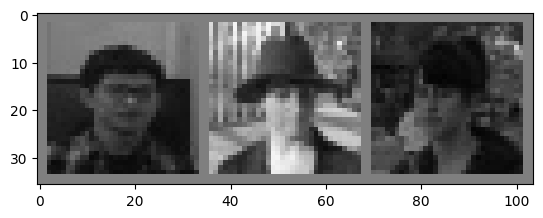

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # Check if the image is grayscale (channel dimension is 1)
    if npimg.shape[0] == 1:
        # Reshape to remove the channel dimension for plotting grayscale images
        plt.imshow(npimg.squeeze(0), cmap='gray')
    else:
        # Transpose for color images (C, H, W) -> (H, W, C)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display 3 images from the batch
print('Labels:', labels[:3])
imshow(torchvision.utils.make_grid(images[:3]))

In [ ]:
# 2. Instantiate the model
net = Primary()

In [ ]:
net2 = SimplePrimary()

In [ ]:
run_name = "Primary_Model_Run4"

In [ ]:
# 2. Run the training process
# You can adjust the hyperparameters here
train_net(net, train_loader, val_loader, test_loader, batch_size=64, learning_rate=0.01, num_epochs=30, _momentum=0.9, auxiliary_weight=0.4, run_name="Primary_Model_Run4")

Epoch 1: Train err: 0.36726666666666663, Train loss: 1.1195946891784667, Train accuracy: 0.6327333333333334, Train Recall: 0.6545261198989765 |Validation err: 0.3284, Validation loss: 1.0333161596298217, Validation accuracy: 0.6716, Validation Recall: 0.6522094926350246
Model saved to /content/drive/My Drive/APS360GroupProject-TrafficSystem/TrainingModels/Primary_Model_Run4_lr0.01_bs64_epoch1.pth
Epoch 2: Train err: 0.27646666666666664, Train loss: 0.9550005982716878, Train accuracy: 0.7235333333333334, Train Recall: 0.6832380699189153 |Validation err: 0.2532, Validation loss: 0.880918871307373, Validation accuracy: 0.7468, Validation Recall: 0.6980360065466449
Model saved to /content/drive/My Drive/APS360GroupProject-TrafficSystem/TrainingModels/Primary_Model_Run4_lr0.01_bs64_epoch2.pth
Epoch 3: Train err: 0.2116, Train loss: 0.835627706972758, Train accuracy: 0.7884, Train Recall: 0.7449155921839692 |Validation err: 0.20320000000000005, Validation loss: 0.8026288429260254, Validation

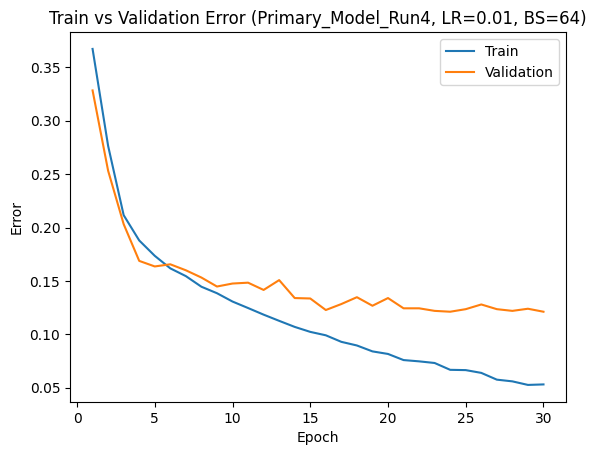

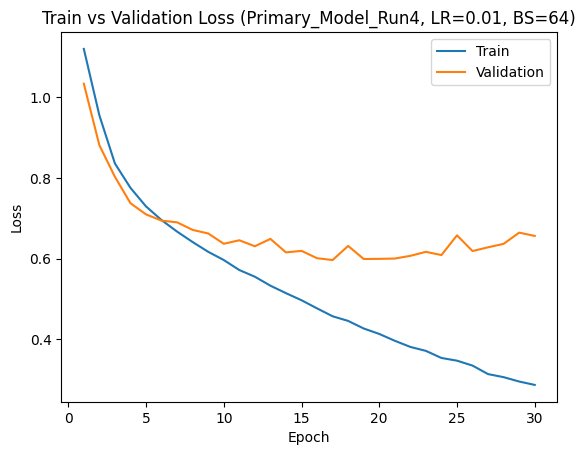

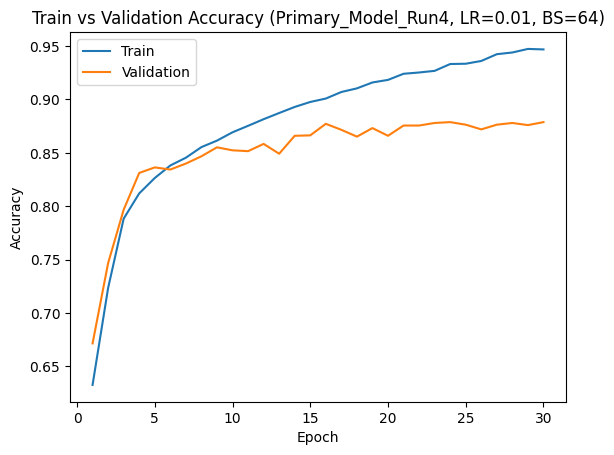

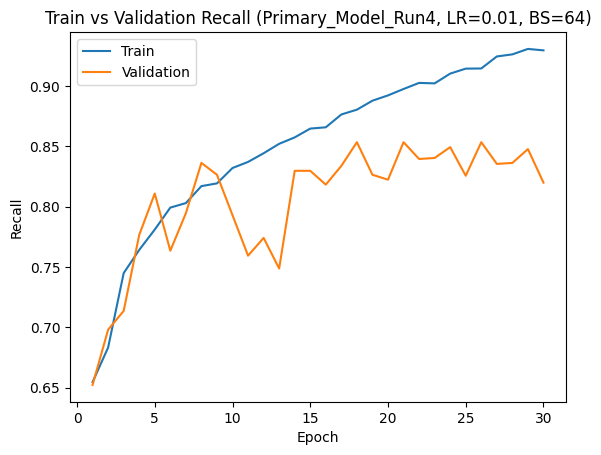

In [ ]:
# 4. Plot the training curve
# Make sure the path matches where the CSV files were saved in train_net
drive_path = '/content/drive/My Drive/APS360GroupProject-TrafficSystem/TrainingModels/'
# You need to specify the run_name, learning_rate, and batch_size used for the training run you want to plot
plot_training_curve(drive_path, run_name="Primary_Model_Run4", learning_rate=0.01, batch_size=64)

Test Error: 0.1180
Test Loss: 0.6795
Test Accuracy: 0.8820
Test Recall: 0.8326
True Positives: 1015
True Negatives: 1190
False Positives: 91
False Negatives: 204

Displaying Sample Test Predictions:
Ground Truth: Distracted, Prediction: Distracted


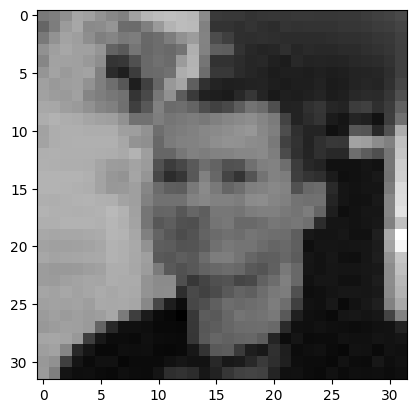

Ground Truth: Attentive, Prediction: Attentive


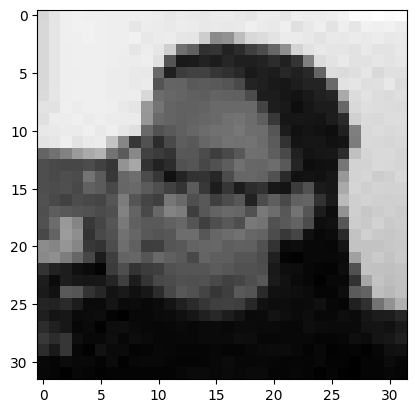

Ground Truth: Attentive, Prediction: Attentive


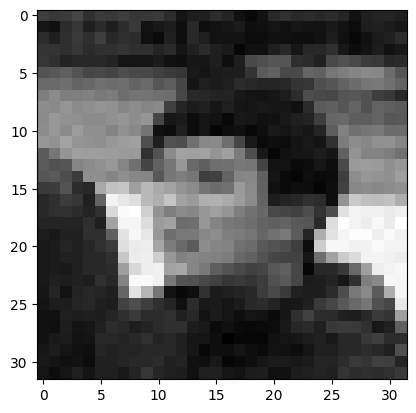

Ground Truth: Distracted, Prediction: Distracted


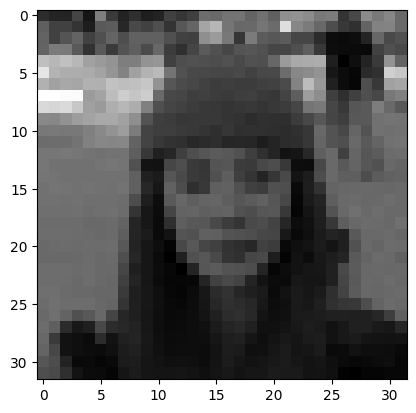

Ground Truth: Distracted, Prediction: Distracted


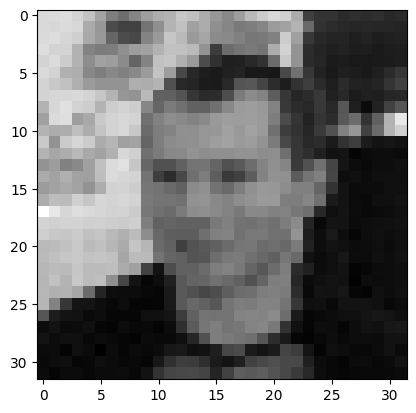

Ground Truth: Attentive, Prediction: Attentive


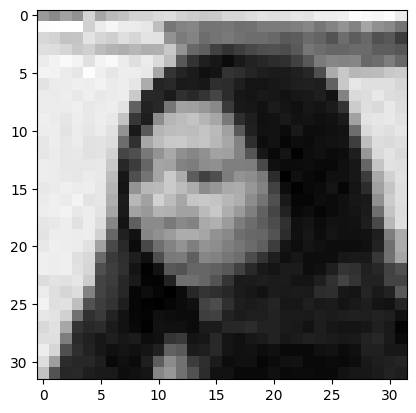

Ground Truth: Distracted, Prediction: Distracted


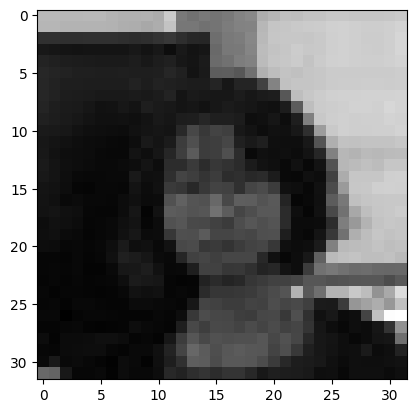

Ground Truth: Attentive, Prediction: Distracted


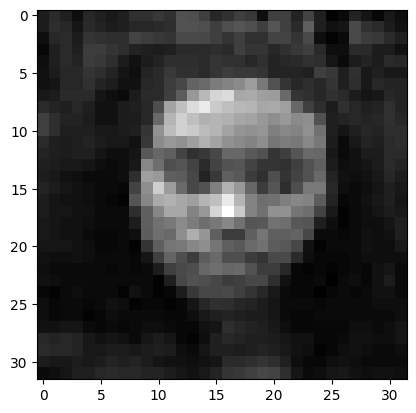

Ground Truth: Attentive, Prediction: Distracted


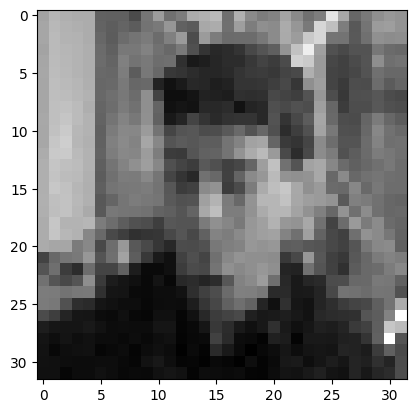

Ground Truth: Distracted, Prediction: Distracted


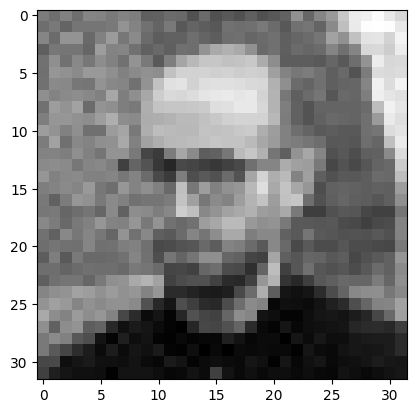

In [ ]:
# 5. Evaluate on the test set
# Load the best model checkpoint or the last one
# For example, loading the model from the last epoch (epoch 10 in the default train_net call)
# IMPORTANT: Replace this with the actual path to your saved Primary model checkpoint
# Updated model_path to point to a checkpoint from the "Primary_Model_Run4" run
model_path = '/content/drive/My Drive/APS360GroupProject-TrafficSystem/TrainingModels/Primary_Model_Run4_lr0.01_bs64_epoch30.pth' # **Replace XX with the desired epoch number**

net_test = Primary() # Create a new instance of the Primary model for evaluation
net_test.load_state_dict(torch.load(model_path))
net_test.eval() # Set the model to evaluation mode

# Make sure data loaders are available (assuming they are defined in a previous cell and accessible)
# train_loader, val_loader, test_loader, unseen_loader = get_data_loader(batch_size=64, total_sample_num=20000)

# Function to show an image (included here for direct availability)
import matplotlib.pyplot as plt
import numpy as np
import torchvision # Import torchvision here if not already imported in this cell

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    # Check the number of dimensions to handle grayscale (2D) or color (3D)
    if npimg.ndim == 2:
        # Grayscale image with shape [H, W]
        plt.imshow(npimg, cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] == 1:
        # Grayscale image with shape [1, H, W], remove channel dimension
        plt.imshow(npimg.squeeze(0), cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] == 3:
        # Color image with shape [3, H, W], transpose to [H, W, C]
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        print(f"Warning: Unexpected image shape for imshow: {npimg.shape}")
        # Fallback: Try to plot as is, might result in error
        plt.imshow(npimg)
    plt.show()


# Evaluate the model on the test set and get accuracy
err, loss, accuracy, true_positives, true_negatives, false_positives, false_negatives, recall = evaluate(net_test, test_loader, auxiliary_weight=0.4) # Pass auxiliary_weight to evaluate and get additional metrics and recall

print(f"Test Error: {err:.4f}")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}") # Print test accuracy
print(f"Test Recall: {recall:.4f}") # Print test Recall
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# --- Display Sample Predictions ---
print("\nDisplaying Sample Test Predictions:")

# Get a few samples from the test loader
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Take the first few images from the batch for demonstration
sample_images = images[:10]
sample_labels = labels[:10]

# Get predictions for the sample images
with torch.no_grad():
    outputs_tuple = net_test(sample_images)
    outputs = outputs_tuple[0] # Main output
    predicted = torch.round(torch.sigmoid(outputs)) # Apply sigmoid and round for binary prediction

# Display images with ground truth and prediction
for i in range(len(sample_images)):
    image = sample_images[i]
    ground_truth = "Attentive" if sample_labels[i].item() == 1 else "Distracted"
    prediction = "Attentive" if predicted[i].item() == 1 else "Distracted"

    print(f"Ground Truth: {ground_truth}, Prediction: {prediction}")
    # Use the imshow function defined within this cell
    # Need to add a dimension for batch size of 1 for imshow if it expects [C, H, W]
    imshow(image.squeeze(0)) # Remove batch dimension if present, imshow expects [C, H, W] or [H, W, C]

In [ ]:
!nvidia-smi

Unseen Data Error: 0.1344
Unseen Data Loss: 0.6184
Unseen Data Accuracy: 0.8656
Unseen Data Recall: 0.8563
True Positives: 2157
True Negatives: 2171
False Positives: 310
False Negatives: 362

Displaying Sample Unseen Data Predictions:
Ground Truth: Attentive, Prediction: Attentive


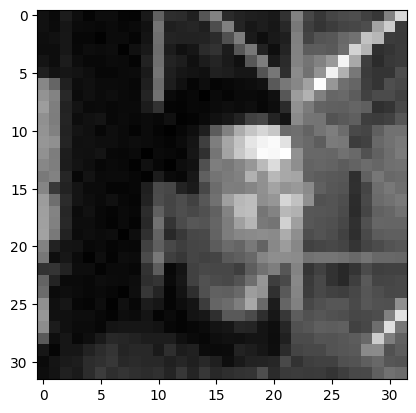

Ground Truth: Attentive, Prediction: Attentive


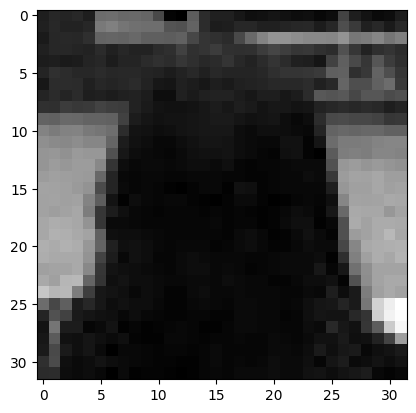

Ground Truth: Attentive, Prediction: Attentive


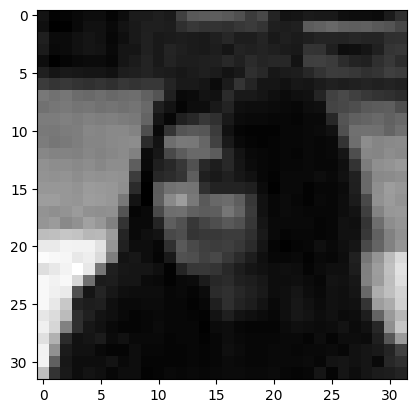

Ground Truth: Distracted, Prediction: Distracted


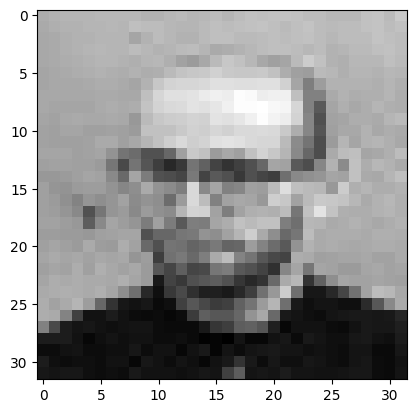

Ground Truth: Attentive, Prediction: Attentive


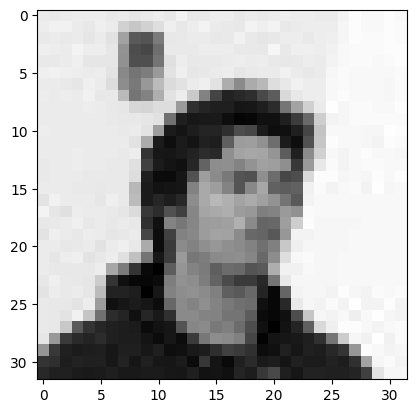

In [ ]:
# 6. Evaluate on the unseen dataset (Copy of Evaluation Cell)
# Load the model checkpoint from Epoch 18 of the Primary_Model_Run4
model_path = '/content/drive/My Drive/APS360GroupProject-TrafficSystem/TrainingModels/Primary_Model_Run4_lr0.01_bs64_epoch18.pth'

net_unseen = Primary() # Create a new instance of the Primary model for evaluation
net_unseen.load_state_dict(torch.load(model_path))
net_unseen.eval() # Set the model to evaluation mode

# Make sure data loaders are available (assuming they are defined in a previous cell and accessible)
# train_loader, val_loader, test_loader, unseen_loader = get_data_loader(batch_size=64, total_sample_num=20000)

# Function to show an image (included here for direct availability)
import matplotlib.pyplot as plt
import numpy as np
import torchvision # Import torchvision here if not already imported in this cell

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    # Check the number of dimensions to handle grayscale (2D) or color (3D)
    if npimg.ndim == 2:
        # Grayscale image with shape [H, W]
        plt.imshow(npimg, cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] == 1:
        # Grayscale image with shape [1, H, W], remove channel dimension
        plt.imshow(npimg.squeeze(0), cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] == 3:
        # Color image with shape [3, H, W], transpose to [H, W, C]
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        print(f"Warning: Unexpected image shape for imshow: {npimg.shape}")
        # Fallback: Try to plot as is, might result in error
        plt.imshow(npimg)
    plt.show()


# Evaluate the model on the unseen set and get metrics
err, loss, accuracy, true_positives, true_negatives, false_positives, false_negatives, recall = evaluate(net_unseen, unseen_loader, auxiliary_weight=0.4) # Use unseen_loader

print(f"Unseen Data Error: {err:.4f}")
print(f"Unseen Data Loss: {loss:.4f}")
print(f"Unseen Data Accuracy: {accuracy:.4f}") # Print unseen data accuracy
print(f"Unseen Data Recall: {recall:.4f}") # Print unseen data Recall
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# --- Display Sample Predictions on Unseen Data ---
print("\nDisplaying Sample Unseen Data Predictions:")

# Get a few samples from the unseen loader
dataiter = iter(unseen_loader)
images, labels = next(dataiter)

# Take the first few images from the batch for demonstration
sample_images = images[:5]
sample_labels = labels[:5]

# Get predictions for the sample images
with torch.no_grad():
    outputs_tuple = net_unseen(sample_images)
    outputs = outputs_tuple[0] # Main output
    predicted = torch.round(torch.sigmoid(outputs)) # Apply sigmoid and round for binary prediction

# Display images with ground truth and prediction
for i in range(len(sample_images)):
    image = sample_images[i]
    ground_truth = "Attentive" if sample_labels[i].item() == 1 else "Distracted"
    prediction = "Attentive" if predicted[i].item() == 1 else "Distracted"

    print(f"Ground Truth: {ground_truth}, Prediction: {prediction}")
    # Use the imshow function defined within this cell
    # Need to add a dimension for batch size of 1 for imshow if it expects [C, H, W]
    imshow(image.squeeze(0)) # Remove batch dimension if present, imshow expects [C, H, W] or [H, W, C]